In [22]:
import cv2 as cv2
import numpy as np
import torch
from torchvision.transforms import ToTensor, Compose, Normalize

from src.colorization.model import UNet
import os
from src.colorization.preprocessing import split_channels
from src.colorization.train import get_val_transform
%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
def batch_hist(examples, channel):
    histograms = []
    for ex in examples:
        histr = cv2.calcHist([ex],[channel],None,[256],[0,256])
        histograms.append(histr)
    histr = np.stack(histograms)
    histr = np.sum(histr, axis=0)
    return histr

In [30]:
image_size = (128,128)
model = UNet(1, 2)


checkpoint = torch.load('/mnt/data/checkpoints/colorization/test_model_22ep.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda()
model = model.eval()
torch.no_grad()

In [4]:
examples = []
examples_gray = []
examples_gray_large = []
folder = '/mnt/data/datasets/ILSVRC2017_CLS-LOC/ILSVRC/Data/CLS-LOC/val'
val_transform = get_val_transform()
val_transform_small = get_val_transform(128)
transform_after_split = Compose([ToTensor()])

to_tensor_l = Compose([ToTensor(),
                       Normalize((0.5,), (0.5,))])
to_tensor_ab = Compose([ToTensor(),
                       Normalize((0.5, 0.5), (0.5, 0.5))])

for file in list(os.listdir(folder))[:30]:
    ex = cv2.imread(os.path.join(folder, file))
    examples.append(cv2.cvtColor(ex, cv2.COLOR_BGR2RGB))
    ex = cv2.cvtColor(ex, cv2.COLOR_BGR2LAB)

    ex_gray_large, _ = split_channels(val_transform(image=ex)['image'])
    ex_gray_large = to_tensor_l(ex_gray_large)
    examples_gray_large.append(ex_gray_large)

    ex_gray_small = split_channels(val_transform_small(image=ex)['image'])
    examples_gray.append(ex_gray_small)


In [31]:
predictions = []
with torch.no_grad():
    for gray in examples_gray_large:
        gray = torch.unsqueeze(gray, 0).cuda()
        result = model(gray)
        result = result.to('cpu')
        predictions.append(result.numpy())

In [32]:
results = []

for i, prediction in enumerate(predictions):
    prediction = np.squeeze(prediction)

    #prediction = cv2.resize(prediction[0, ...], (examples_gray_large[i].shape[1], examples_gray_large[i].shape[0]), interpolation=cv2.INTER_CUBIC)
    result = np.stack([examples_gray_large[i][0, ...], prediction[0, ...], prediction[1, ...]], axis=0)
    result = np.transpose(result, (1, 2, 0))
    result /= 2.
    result += 0.5
    result *= 255.
    result = np.around(result).astype('uint8')
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    results.append(result)

In [15]:
#write out all images as individual files: color, gray, prediction
target_dir = '/mnt/data/tmp_predictions/'
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for i in range(len(results)):
    cv2.imwrite(os.path.join(target_dir, '%d_color.png' % i), cv2.cvtColor(examples[i], cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(target_dir, '%d_gray.png' % i), (examples_gray_large[i][...,0] +1.)*128.)
    cv2.imwrite(os.path.join(target_dir, '%d_prediction.png' % i), cv2.cvtColor(results[i], cv2.COLOR_RGB2BGR))

In [33]:
pixel_count = 0
for ex in results:
    h, w, _ = ex.shape
    pixel_count += (h*w)


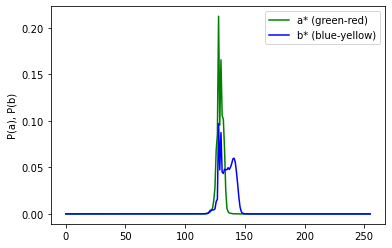

In [34]:
color = ('g','b')
import random
#exampes = random.shuffle(examples)
lab = []
for res in results:
    lab.append(cv2.cvtColor(res, cv2.COLOR_RGB2LAB))

pred_hist = []
for i,col in enumerate(color):
    histr = batch_hist(lab, i+1)
    #print(histr)
    histr /= pixel_count
    pred_hist.append(histr)
    plt.plot(histr, color = col)
    #plt.xlim([-1,1])
    
plt.ylabel('P(a), P(b)')
plt.legend(['a* (green-red)', 'b* (blue-yellow)'])
#plt.savefig('logs/unet_alt_large_256_variable_l2_b8_imagnet/histogram.png', dpi=144)
plt.show()


In [10]:
with open('pred_histogram_l1_b8.npy', 'wb+') as file:
    np.save(file, pred_hist)

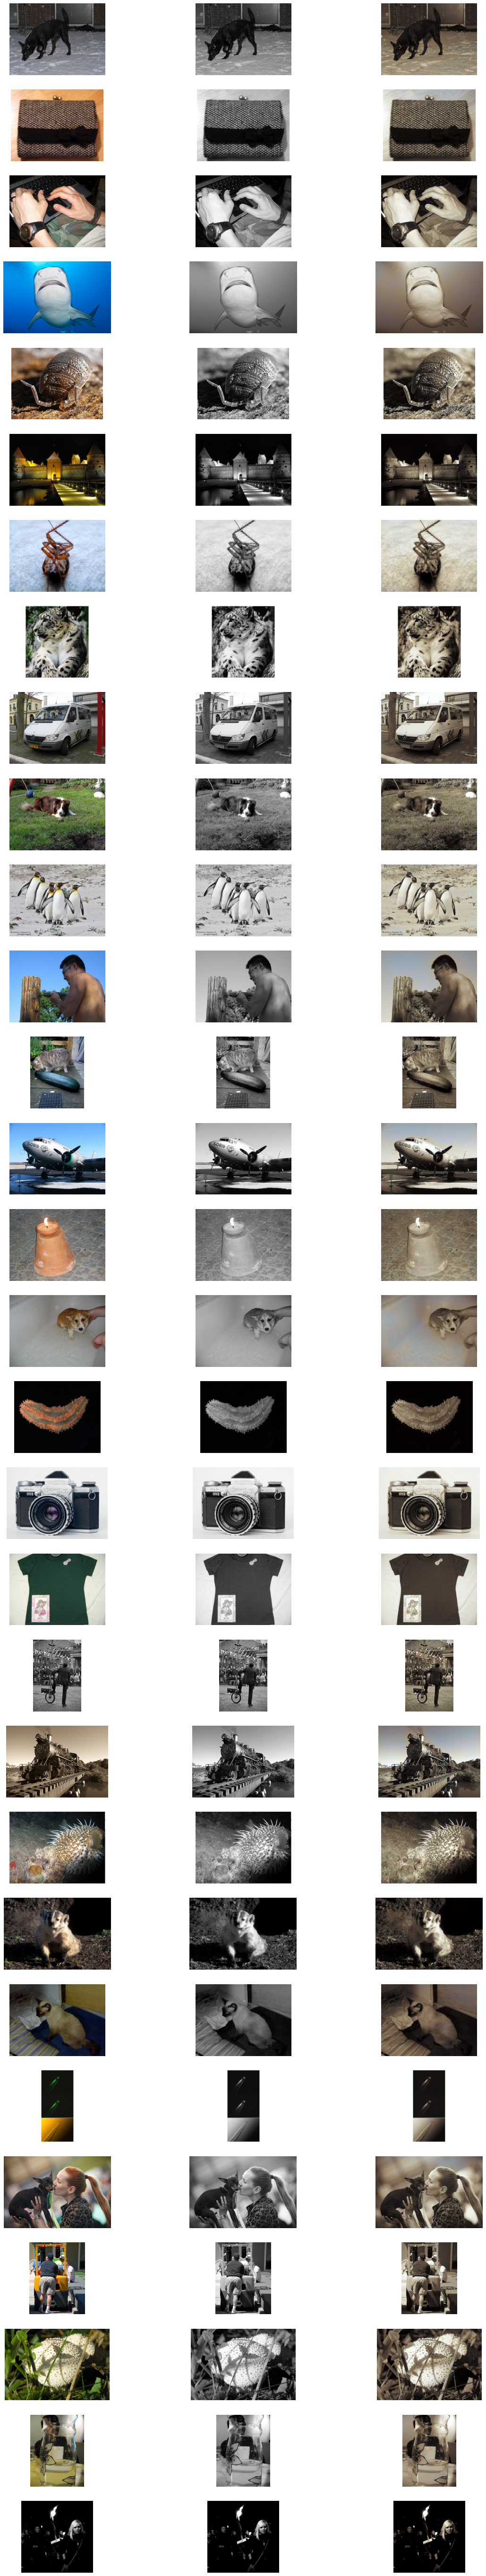

In [35]:
f, axarr = plt.subplots(len(results[:30]),3, figsize=(20,100))

for i in range(len(results[:30])):
    axarr[i, 0].imshow(examples[i])
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(examples_gray_large[i][0, ...], cmap='gray', vmin=-1, vmax=1)
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(results[i])
    axarr[i, 2].axis('off')

plt.show()

In [39]:
f.savefig('test_model.png')

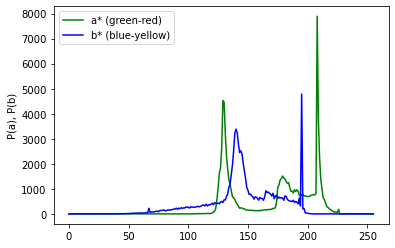

In [51]:
index = 20
pixel_count = predictions[index].shape[0] * predictions[index].shape[1]



color = ('g','b')
import random
#exampes = random.shuffle(examples)
lab = []
for res in [results[index]]:
    lab.append(cv2.cvtColor(res, cv2.COLOR_RGB2LAB))

pred_hist = []
for i,col in enumerate(color):
    histr = batch_hist(lab, i+1)
    #print(histr)
    histr /= pixel_count
    pred_hist.append(histr)
    plt.plot(histr, color = col)
    #plt.xlim([-1,1])

plt.ylabel('P(a), P(b)')
plt.legend(['a* (green-red)', 'b* (blue-yellow)'])
#plt.savefig('logs/unet_alt_large_256_variable_l2_b8_imagnet/histogram.png', dpi=144)
plt.show()

